In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [3]:
def mlmc_gbm(l,Nl,T=1,M=2):
    Nsteps=M**l
    dt=T/Nsteps
    sqrt_dt=np.sqrt(dt)
    W=np.random.randn(Nsteps,Nl)*sqrt_dt
    P_l=calc_P_l(W,dt)
    sum1=sum(P_l)
    sum2=sum(P_l**2)
    
    if l==0:
        return [sum1,sum2,sum1,sum2]
    else:
        Wnew=W[0::M,:]
        for m in range(1,M):
            Wnew+=W[m::M,:]
        P_lm1=calc_P_l(Wnew,M*dt)
        dP_l=P_l-P_lm1
        return [sum(dP_l),sum(dP_l**2),sum1,sum2]
    
def calc_P_l(W,dt,X0=100,T=1):
    '''
    __THIS VERSION DOESN'T TRANSFORM X TO EXP, HENCE X CAN GO NEGATIVE__
    Inputs: W (matrix of Nsteps x Nl random numbers ~ N(0,1))
    Outputs: h(X) (payoff for each of the Nl paths)
    Calculate X for Nl paths over Nsteps 
    '''
    Nsteps,Nl=np.shape(W)
    X=X0*np.ones(Nl)
    for i in range(Nsteps):
        X+=r*X*dt + sig*X*W[i,:]
    X[X<0]=0
    return np.exp(-0.05*T)*X


In [4]:
Y=np.sum(calc_P_l(np.random.randn(T,N0),T))/N0
print(f'Y0 = {Y}')
Ys=[Y]
for l in range(1,Lmax+1):
    Ys+=[calc_Yl(l)]
    Y+=Ys[-1]
print(f'Y_L = {Y}')


Y0 = 12.217226038132877
Y_L = 12.476140966224163


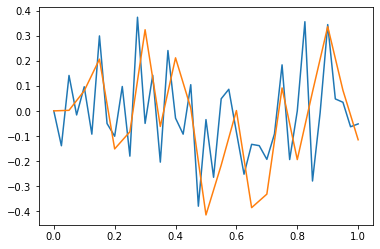

In [5]:
Nsteps=40
Nl=1
dt=T/Nsteps
steps1=np.arange(dt,T+dt,dt)
W=np.random.randn(Nsteps,Nl)*np.sqrt(dt)

Wnew=W[0::2,:]+W[1::2,:]
Nsteps,Nl=np.shape(Wnew)
dt=T/Nsteps
steps2=np.arange(dt,T+dt,dt)
steps1=[0]+list(steps1)
steps2=[0]+list(steps2)

W=[0]+list(W)
Wnew=[0]+list(Wnew)

plt.plot(steps1,W)
plt.plot(steps2,Wnew)

In [7]:
#Exact result according to BS formula
D1 =(r+sig**2/2)/sig
D2 = D1 - sig
print(100*norm.cdf(D1)-100*np.exp(-r)*norm.cdf(D2))


12.335998930368717
